In [2]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

# 데이터
- CIFAR-100 데이터 사용
    - normalize
    - 정수 레이블을 ont-hot vector로 변환

169017344/169001437 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 100) (10000, 100)


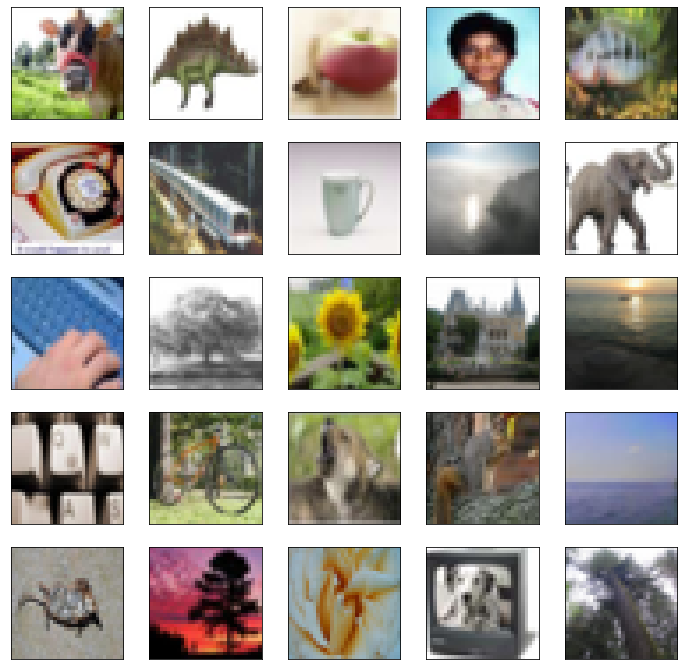

In [4]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

plt.figure(figsize = (12, 12))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])

plt.show()

# 하이퍼파라미터 값 셋팅
- `patch_size`

In [5]:
patch_size = (2, 2)
dropout_rate = 0.03
num_heads = 8
embed_dim = 64
num_mlp = 256
qkv_bias = True # 임베딩된 patch를 query, key, value값으로 변환
window_size = 2
shift_size = 1
image_dimension = 32

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 40
validation_split = .1
weight_decay = 0.0001
label_smoothing = 0.1

# 함수값 불러오기
1. sequence of patches from the image
2. merge patches
3. apply dropout

In [6]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size

    x = tf.reshape(x, shape = (-1, patch_num_y, window_size, patch_num_x, window_size, channels))
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape = (-1, window_size, window_size, channels))

    return windows

def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size

    x = tf.reshape(windows, shape = (-1, patch_num_y, patch_num_x, window_size, window_size, channels),)
    x = tf.transpose(x, perm = (0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape = (-1, height, width, channels))

    return x

class DropPath(layers.Layer):
    def __init__(self, drop_prob = None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size, ) + (1, ) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype = x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask

        return output

# Window 기반 MSA
- 보통 Transformer 계열은 global self-attention 사용하나 Swin Transformer는 local window에서 self-attention 연산을 수행한다. 

- window 기반 MSA는 linear complexity를 유도하며 좀 더 쉽게 scale 가능하다

In [7]:
class WindowAttention(layers.Layer):
    def __init__(self, dim, window_size, num_heads, qkv_bias = True, dropout_rate = 0.0, **kwargs):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias = qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1)
        self.relative_position_bias_table = self.add_weight(shape = (num_window_elements, self.num_heads),
                                                            initializer = tf.initializers.Zeros(),
                                                            trainable = True)
        
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing = 'ij')
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)

        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(initial_value = tf.convert_to_tensor(relative_position_index), trainable = False)

    def call(self, x, mask = None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape = (-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm = (2, 0, 3, 1, 4))

        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm = (0, 1, 3, 2))
        attn = q @ k


        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(self.relative_position_index, shape = (-1, ))
        relative_position_bias = tf.gather(self.relative_position_bias_table, relative_position_index_flat)
        relative_position_bias = tf.reshape(relative_position_bias, shape = (num_window_elements, num_window_elements, -1))
        relative_position_bias = tf.transpose(relative_position_bias, perm = (2, 0, 1))

        attn = attn + tf.expand_dims(relative_position_bias, axis = 0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(tf.expand_dims(tf.expand_dims(mask, axis = 1), axis = 0), tf.float32)
            attn = (tf.reshape(attn, shape = (-1, nW, self.num_heads, size, size)) + mask_float)
            attn = tf.reshape(attn, shape = (-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis = -1)
        else:
            attn = keras.activations.softmax(attn, axis = -1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm = (0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape = (-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)

        return x_qkv

# Swin Transformer

- 2개의 Dense, 2개의 Dropout 레이어를 가지는 단순한 MLP 생성

- 보통 Backbone으로 ResNet을 사용할 수 있으나 본 논문에선 2MLP, GELU 사용

In [8]:
class SwinTransformer(layers.Layer):
    def __init__(self, dim, 
                 num_patch, 
                 num_heads, 
                 window_size = 7, 
                 shift_size = 0, 
                 num_mlp = 1024, 
                 qkv_bias = True, 
                 dropout_rate = 0.0, 
                 **kwargs):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim
        self.num_patch = num_patch
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.num_mlp = num_mlp

        self.norm1 = layers.LayerNormalization(epsilon = 1e-5)
        self.attn = WindowAttention(dim, 
                                    window_size = (self.window_size, self.window_size), 
                                    num_heads = num_heads,
                                    qkv_bias = qkv_bias,
                                    dropout_rate = dropout_rate)
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon = 1e-5)
        self.mlp = keras.Sequential([
                                     layers.Dense(num_mlp),
                                     layers.Activation(keras.activations.gelu),
                                     layers.Dropout(dropout_rate),
                                     layers.Dense(dim),
                                     layers.Dropout(dropout_rate)
         ])

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)


    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None)
            )
            mask_array = np.zeros((1, height, width, 1))
            
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask_array를 window로
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(mask_windows, shape = [-1, self.window_size * self.window_size])
            attn_mask = tf.expand_dims(mask_windows, axis = 1) - tf.expand_dims(mask_windows, axis = 2)
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value = attn_mask, trainable = False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape = (-1, height, width, channels))

        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift = [-self.shift_size, -self.shift_size], axis = [1, 2])
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(x_windows, shape = (-1, self.window_size * self.window_size, channels))
        attn_windows = self.attn(x_windows, mask = self.attn_mask)
        attn_windows = tf.reshape(attn_windows, shape = (-1, self.window_size, self.window_size, channels))
        shifted_x = window_reverse(attn_windows, self.window_size, height, width, channels)

        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift = [self.shift_size, self.shift_size], axis = [1, 2])
        else:
            x = shifted_x

        x = tf.reshape(x, shape = (-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x

        return x

# 모델 학습 및 평가


In [9]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim = num_patch, output_dim = embed_dim)

    def call(self, patch):
        pos = tf.range(start = 0, limit = self.num_patch, delta = 1)

        return self.proj(patch) + self.pos_embed(pos)

class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias = False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape = (-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))

        return self.linear_trans(x)

# 모델 정의

In [10]:
input = layers.Input(input_shape)

x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip('horizontal')(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim = embed_dim,
    num_patch = (num_patch_x, num_patch_y),
    num_heads = num_heads,
    window_size = window_size,
    shift_size = 0,
    num_mlp = num_mlp,
    qkv_bias = qkv_bias,
    dropout_rate = dropout_rate
)(x)
x = SwinTransformer(
    dim = embed_dim,
    num_patch = (num_patch_x, num_patch_y),
    num_heads = num_heads,
    window_size = window_size,
    shift_size = shift_size,
    num_mlp = num_mlp,
    qkv_bias = qkv_bias,
    dropout_rate = dropout_rate
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim = embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)

output = layers.Dense(num_classes, activation = 'softmax')(x)

# 데이터셋 학습

In [11]:
model = keras.Model(input, output)

model.compile(
    loss = keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing),
    optimizer = tfa.optimizers.AdamW(learning_rate = learning_rate, weight_decay = weight_decay),
    metrics = [
               keras.metrics.CategoricalAccuracy(name = 'accuracy'),
               keras.metrics.TopKCategoricalAccuracy(5, name = 'top-5-accuracy')
    ])

hist = model.fit(
    x_train, 
    y_train,
    batch_size = batch_size,
    epochs = num_epochs,
    validation_split = validation_split)

Epoch 1/40
352/352 [==============================] - 72s 148ms/step - loss: 4.1728 - accuracy: 0.0781 - top-5-accuracy: 0.2488 - val_loss: 3.8967 - val_accuracy: 0.1260 - val_top-5-accuracy: 0.3536
Epoch 2/40
352/352 [==============================] - 53s 150ms/step - loss: 3.7569 - accuracy: 0.1539 - top-5-accuracy: 0.4076 - val_loss: 3.6850 - val_accuracy: 0.1690 - val_top-5-accuracy: 0.4400
Epoch 3/40
352/352 [==============================] - 51s 145ms/step - loss: 3.5623 - accuracy: 0.2009 - top-5-accuracy: 0.4810 - val_loss: 3.5301 - val_accuracy: 0.2054 - val_top-5-accuracy: 0.5088
Epoch 4/40
352/352 [==============================] - 51s 145ms/step - loss: 3.4379 - accuracy: 0.2289 - top-5-accuracy: 0.5237 - val_loss: 3.4323 - val_accuracy: 0.2312 - val_top-5-accuracy: 0.5218
Epoch 5/40
352/352 [==============================] - 51s 144ms/step - loss: 3.3247 - accuracy: 0.2562 - top-5-accuracy: 0.5612 - val_loss: 3.3271 - val_accuracy: 0.2644 - val_top-5-accuracy: 0.5646
Epoch

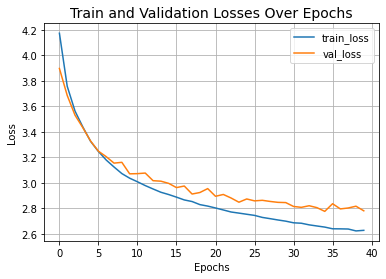

In [12]:
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [13]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 [==============================] - 9s 30ms/step - loss: 2.7408 - accuracy: 0.4202 - top-5-accuracy: 0.7268
Test loss: 2.74
Test accuracy: 42.02%
Test top 5 accuracy: 72.68%
